In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, neighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import math
from sklearn.decomposition import TruncatedSVD

<b> The immediate code block below does the following things :</b>
<br>
<ol>
    <li>Load the Amazon dataset.</li>

<li>Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.</li>
<li>Remove duplicate/redundant datas.</li>
<li>Get an idea of how much percentage data were actually duplicates.</li>
<li>Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.</li>
</ol>

In [3]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite') 

#Filter only positive and negative reviews. Do nbot consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


<b>In this code block :</b><br>
<ol>
<li>I am creating a copy of the final_data dataset called 'sampled_dataset' by dropping the unwanted columns that we don't need for this problem.</li>
<li>Sorting the data according to time, such that the oldest reviews are displayed at the top and the latest reviews are displayed at the bottom.</li>
<li>Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram.</li>
    </ol>

The shape of the sampled dataset after dropping unwanted columns :  (364171, 4)

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0
1,1351209600,Very pleased with the quality of the espresso....,Positive,1
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1
7,1351209600,try it & we shared with the familys/all han th...,Positive,1
8,1351209600,If you like butter flavor this is the best mic...,Positive,1
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1


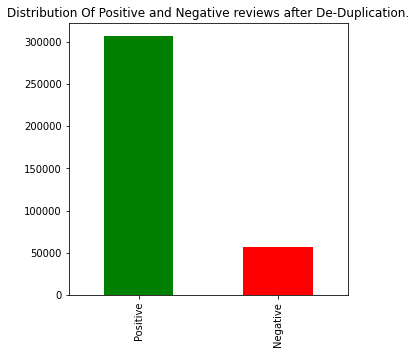

In [4]:
'''Creating a sampled dataset dropping the unwanted columns that we don't need for this problem, from the actual dataset.'''
#Creating a subset of the "final_data" table with randomly selecting 360000 samples
#sampled_dataset = final_data.sample(n=360000, replace=False, random_state=0).reset_index()
#print("\nThe shape of the sampled dataset : ", sampled_dataset.shape)

#Dropping unwanted columns for now.
sampled_dataset=final_data.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], axis=1)
print("The shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Display distribution of Postive and Negative reviews in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset (All the reviews are arranged according to time)
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

<b>In this code block :</b><br>
<ol>
<li>We define two functions which will remove the HTML tags and punctuations from each review.</li>
<li>At the end of this code block, each review will contain texts which will only contain alphabetical strings.</li>
<li>We will apply techniques such as stemming and stopwords removal.</li>
<li>We will create two columns in the sampled dataset - 'CleanedText' and 'RemovedHTML'.</li>
<li>'CleanedText' column will basically contain the data corpus after stemming the each reviews and removing stopwords from each review. We will use this for our Bag of Word model.</li>
<li>'RemovedHTML' column will contain the data corpus from which only the HTML tags and punctuations are removed. We will use this column for our TF-IDF model, Average Word2Vec model and TF-IDF weighted average Word2Vec model.</li>
<li>Store the final table in a dataset called 'sampled_dataset' for future use.</li>
</ol>

In [5]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

from tqdm import tqdm

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews.    
count=0                   #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
data_corpus=[]
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
stemed_word=''
for review in tqdm(sampled_dataset['Text'].values):
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): #Checking if a word consists of only alphabets + word length is greater than 2.    
                if(cleaned_words.lower() not in custom_stopwords):
                    stemed_word=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(stemed_word)
                    if (sampled_dataset['SentimentPolarity'].values)[count] == 'Positive': 
                        all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
                    if(sampled_dataset['SentimentPolarity'].values)[count] == 'Negative':
                        all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
                else:
                    continue
            else:
                continue 
    string = " ".join(filtered_sentence) #Final string of cleaned words    
    data_corpus.append(string) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
    
print("The length of the data corpus is : {}".format(len(data_corpus)))

#Building a data corpus by removing only the Punctuations and HTML tags. Stopwords are preserved. Words are not stemmed. This is useful for Average Word2Vec, TF-IDF W2V.
string=' '    
not_stemmed_corpus=[]
for review in tqdm(sampled_dataset['Text'].values):
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha()): #Checking if a word consists of only alphabets    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    string = " ".join(filtered_sentence)    
    not_stemmed_corpus.append(string) 
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['CleanedText']=data_corpus 

#Adding a column of PreserveStopwords to the table final which stores the data corpus in which stopwords are preserved and words are not stemmed.  
sampled_dataset['PreserveStopwords']=not_stemmed_corpus 

print("Printing the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())

"""#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)
"""

  0%|          | 712/364171 [00:00<00:51, 7116.39it/s]

The length of the data corpus is : 364171


100%|██████████| 364171/364171 [01:04<00:00, 5635.97it/s]


Printing the number of positive and negative reviews after data cleaning.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64


'#Store final table into an SQlLite table for future.\nconnection_sqlobject = sqlite3.connect(\'sampled_dataset_all_reviews.sqlite\')\nc=connection_sqlobject.cursor()\nconnection_sqlobject.text_factory = str\nsampled_dataset.to_sql(\'Reviews\', connection_sqlobject, schema=None, if_exists=\'replace\', index=True, index_label=None, chunksize=None, dtype=None)\n\n#Display the first 10 rows of the sampled_dataset.\nprint("\nFirst 10 rows of the sampled_dataset.")\nsampled_dataset.head(10)\n'

In [6]:
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)


First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels,CleanedText,PreserveStopwords
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0,got coffe day ago coffe bean yesterday today m...,i just got this coffee a few days ago i had co...
1,1351209600,Very pleased with the quality of the espresso....,Positive,1,pleas qualiti espresso pod sturdi enough withs...,very pleased with the quality of the espresso ...
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1,bought new oster belgium waffl maker best waff...,bought this with my new oster belgium waffle m...
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0,drink lot tea world far worst tast tea purchas...,we drink a lot of tea from all over the world ...
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1,alway bought pure vanilla extract mexico got t...,i have always bought my pure vanilla extract i...
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1,label cadburi screme egg allergi inform manufa...,from the label on the cadbury screme egg aller...
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1,best soup mix tri love make soup best tast eas...,best soup mix i ve tried i love making soup an...
7,1351209600,try it & we shared with the familys/all han th...,Positive,1,tri share famili han thumb cut good lite oliv ...,try it we shared with the familys all han thum...
8,1351209600,If you like butter flavor this is the best mic...,Positive,1,like butter flavor best microwav popcorn avail...,if you like butter flavor this is the best mic...
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1,love sort tea friend know travel often bring t...,i love all sorts of teas my friends know this ...


<b>In this code block :</b><br>
<ol>
<li>We define a function which is used to seperate the positive and the negative data points for any input dataset using their corresponding class labels, using KNN algorithm.</li> 
    <li>We split the input dataset into train set and test set. For the training set I have taken the old 80% data. For the test set I have taken the latest 20% data. The idea here is to see how the model behaves when it's tested on 'new unseen' data after getting trained on an old data.</li>
<li>We use cross validation to determine the optimal value of K, and use this value of K as our number nearest neighbours to train the final model.</li>
<li>Finally, we will use accuracy as a metric to evaluate this models performance on unseen data.</li>

</ol>

In [15]:
#Sample the data 5000 records
X = sampled_dataset['CleanedText'][0:5000]
Y = sampled_dataset['Class_Labels'][0:5000]
#Split the dataset to train and test
split = int(0.8*X.shape[0])
X_train = X[0:split]; X_test = X[split:];
Y_train = Y[0:split]; Y_test = Y[split:];

from sklearn.neighbors import KNeighborsClassifier

In [80]:
# Defining the function for KNN alogorithm
def knn_algo(X_train, Y_train, X_test, Y_test, vectorizer_type):
    X_train = X_train; Y_train=Y_train; X_test=X_test; Y_test=Y_test;
    cross_val_scores=[]
    print("Starting the cross-validation steps for {} Vectoriser".format(vectorizer_type))
    for n in range(1,50,2):
        knn_classifier = KNeighborsClassifier(n_neighbors = n, weights="distance", algorithm="brute", p=2, metric='minkowski', n_jobs=-1)
        accuracies = cross_val_score(knn_classifier, X_train_vectors, y=Y_train, cv=10, n_jobs=-1)
        cross_val_scores.append(accuracies.mean())

    k_values = np.arange(1,50,2)
    errors = [1 - x for x in cross_val_scores]
    optimal_k = k_values[errors.index(min(errors))]
    print("\n The optimal number of neighbors for K-NN brute-force algo is: {}".format(optimal_k))

    plt.figure(figsize=(12,6))
    plt.plot(k_values, np.round(errors, 3), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=5)
    for xy in zip(k_values, np.round(errors, 3)):
        plt.annotate(xy,xy)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Errors")
    plt.title("Plot of Errors vs #of Neighbors")

    knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k, weights='distance', algorithm='brute',p=2, metric='minkowski', n_jobs=-1)
    knn_classifier.fit(X_train_vectors, Y_train)
    y_pred = knn_classifier.predict(X_test_vectors)

    test_accuracy = accuracy_score(Y_test, y_pred,normalize=True)*100
    print("The accuracy on test dataset is: {}%".format(test_accuracy))
    points = accuracy_score(Y_test, y_pred,normalize=False)
    print("The number of accurate predicitons out of {} for k: {} is {}".format(Y_test.shape[0], optimal_k, points))

    # Precision, recal and F1 for this model
    print("Accuracy of the model on the unseen data for the k: {} is {}".format(optimal_k, np.round(metrics.accuracy_score(Y_test ,y_pred), 4)*100))
    print("Precision of the model on the unseen data for the k: {} is {}".format(optimal_k, np.round(metrics.precision_score(Y_test ,y_pred), 4)*100))
    print("Recall of the model on the unseen data for the k: {} is {}".format(optimal_k, np.round(metrics.recall_score(Y_test ,y_pred), 4)*100))
    print("F1 Score of the model on the unseen data for the k: {} is {}".format(optimal_k, np.round(metrics.f1_score(Y_test ,y_pred), 4)*100))

    # Classification report
    print(metrics.classification_report(Y_test, y_pred))

    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(Y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(Y_test ,y_pred)*100,2)))

    sciplot.plot_confusion_matrix(Y_test ,y_pred)

    #Save the below list for later use to display model information
    info_model_KNN = [vectorizer_type, optimal_k, np.round(np.array(errors).mean(),4), np.round(1-metrics.accuracy_score(Y_test, y_pred),4), np.round(metrics.f1_score(Y_test ,y_pred),4)]
    with open('info_model_KNN.txt', 'a') as file:  
        file.writelines("%s " % iterator for iterator in info_model_KNN)
        file.writelines("\n")

    #Freeing memory allocations    
    del(X_train, Y_train, X_test, Y_test, y_pred, knn_classifier)

<b>KNN on the Bag of Words model created using 'CleanedText'.</b>


Creating the BOW vectors using the cleaned corpus
Starting the cross-validation steps for Bag-of-models Vectoriser

 The optimal number of neighbors for K-NN brute-force algo is: 5
The accuracy on test dataset is: 86.7%
The number of accurate predicitons out of 1000 for k: 5 is 867
Accuracy of the model on the unseen data for the k: 5 is 86.7
Precision of the model on the unseen data for the k: 5 is 86.76
Recall of the model on the unseen data for the k: 5 is 99.88
F1 Score of the model on the unseen data for the k: 5 is 92.86
              precision    recall  f1-score   support

           0       0.67      0.01      0.03       134
           1       0.87      1.00      0.93       866

    accuracy                           0.87      1000
   macro avg       0.77      0.51      0.48      1000
weighted avg       0.84      0.87      0.81      1000


Of all the reviews that the model has predicted to be positive, 86.76% of them are actually positive.
Of all the reviews that are actually

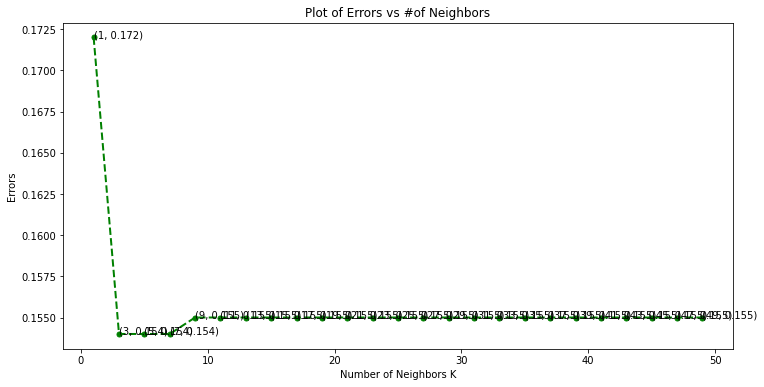

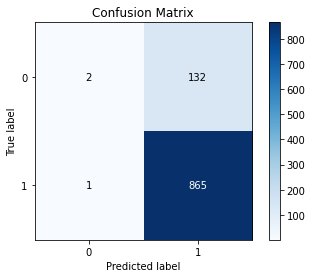

In [81]:
#Creating the BOW for cleaned text
count_vectoriser = CountVectorizer().fit(X_train)
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = count_vectoriser.transform(X_train)
X_test_vectors = count_vectoriser.transform(X_test)

#Standardise the data
from sklearn.preprocessing import StandardScaler
standard_scalar = StandardScaler(with_mean=False).fit(X_train_vectors)
X_train_vectors = standard_scalar.transform(X_train_vectors)
X_test_vectors = standard_scalar.transform(X_test_vectors)

knn_algo(X_train_vectors, Y_train, X_test_vectors, Y_test, "Bag-of-models")

<b>KNN on the TF-IDF model created using 'CleanedText' texts.</b>



Creating the TFIDF vectors using the cleaned corpus
Starting the cross-validation steps for TF-IDF Vectoriser

 The optimal number of neighbors for K-NN brute-force algo is: 3
The accuracy on test dataset is: 86.8%
The number of accurate predicitons out of 1000 for k: 3 is 868
Accuracy of the model on the unseen data for the k: 3 is 86.8
Precision of the model on the unseen data for the k: 3 is 86.92
Recall of the model on the unseen data for the k: 3 is 99.77000000000001
F1 Score of the model on the unseen data for the k: 3 is 92.9
              precision    recall  f1-score   support

           0       0.67      0.03      0.06       134
           1       0.87      1.00      0.93       866

    accuracy                           0.87      1000
   macro avg       0.77      0.51      0.49      1000
weighted avg       0.84      0.87      0.81      1000


Of all the reviews that the model has predicted to be positive, 86.92% of them are actually positive.
Of all the reviews that are ac

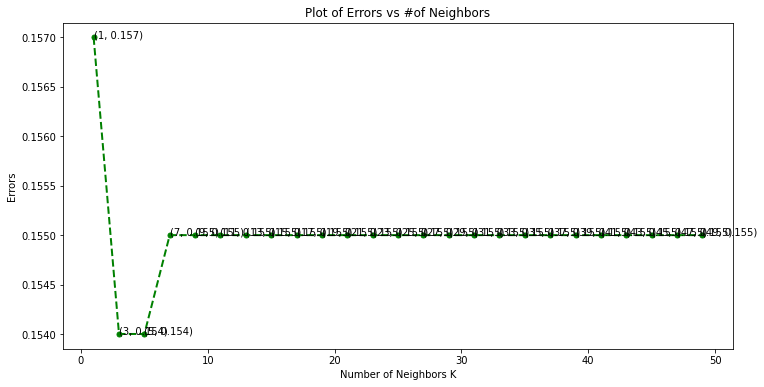

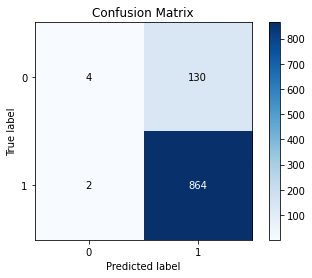

In [82]:
#Creating the TFIDF Vectors for cleaned text
tfidf_vectoriser = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)
print("\nCreating the TFIDF vectors using the cleaned corpus")
X_train_vectors = tfidf_vectoriser.transform(X_train)
X_test_vectors = tfidf_vectoriser.transform(X_test)

#Standardise the data
from sklearn.preprocessing import StandardScaler
standard_scalar = StandardScaler(with_mean=False).fit(X_train_vectors)
X_train_vectors = standard_scalar.transform(X_train_vectors)
X_test_vectors = standard_scalar.transform(X_test_vectors)

knn_algo(X_train_vectors, Y_train, X_test_vectors, Y_test, "TF-IDF")

<b>KNN on the Average Word2Vec using a 50 dimensional vector representation of each word.</b>


In [83]:
#Sample the data 5000 records to save the time
X = sampled_dataset['PreserveStopwords'][0:5000]
Y = sampled_dataset['Class_Labels'][0:5000]
#Split the dataset to train and test
split = int(0.8*X.shape[0])
X_train = X[0:split]; X_test = X[split:];
Y_train = Y[0:split]; Y_test = Y[split:];


The length of the sentence vectors : 4000

Size of each vector :  50

The length of the sentence vectors : 1000

Size of each vector :  50
Starting the cross-validation steps for Average-Word2Vec Vectoriser

 The optimal number of neighbors for K-NN brute-force algo is: 19
The accuracy on test dataset is: 86.6%
The number of accurate predicitons out of 1000 for k: 19 is 866
Accuracy of the model on the unseen data for the k: 19 is 86.6
Precision of the model on the unseen data for the k: 19 is 86.6
Recall of the model on the unseen data for the k: 19 is 100.0
F1 Score of the model on the unseen data for the k: 19 is 92.82000000000001
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.87      1.00      0.93       866

    accuracy                           0.87      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.75      0.87      0.80      1000


Of all the reviews that the m

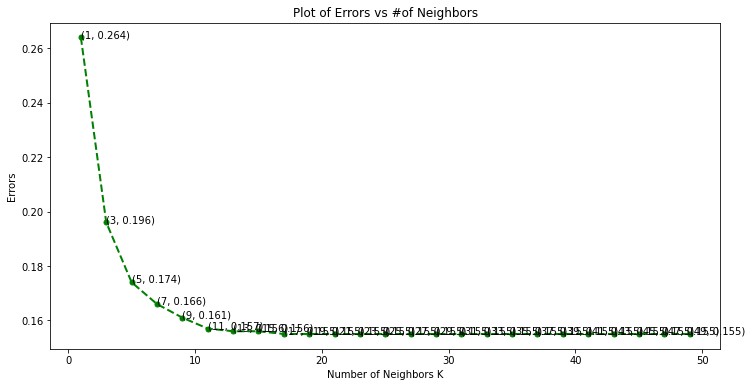

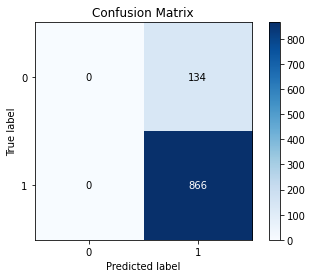

In [90]:
def w2v_vectorize(data):
    word2vec_corpus = [];
    count = 0;
    sent_vectors = [];
    for sentence in data:
        word2vec_corpus.append(sentence.split());
    word2vec_model = Word2Vec(sentences=word2vec_corpus, vector_size=50, min_count=5, workers=6);
    word2vec_words = list(word2vec_model.wv.index_to_key)
    
    for sentence in data:
        sent_vec = np.zeros(50)
        for word in sentence:
            if word in word2vec_words:
                w2v = word2vec_model.wv[word];
                sent_vec += w2v
                count += 1
        if count != 0:
            sent_vec /= count
        sent_vectors.append(sent_vec)
    print("\nThe length of the sentence vectors :",len(sent_vectors))
    print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors

X_train_vectors = w2v_vectorize(X_train)
X_test_vectors = w2v_vectorize(X_test)

#Standardise the data
from sklearn.preprocessing import StandardScaler
standard_scalar = StandardScaler(with_mean=False).fit(X_train_vectors)
X_train_vectors = standard_scalar.transform(X_train_vectors)
X_test_vectors = standard_scalar.transform(X_test_vectors)

knn_algo(X_train_vectors, Y_train, X_test_vectors, Y_test, "Average-Word2Vec")
        
                
                

<b>KNN on the TF-IDF weighted Average Word2Vec representation on the reviews.</b>

The shape of the X_train_vectors is : (4000, 50)
The shape of the X_test_vectors is : (1000, 50)
Starting the cross-validation steps for TF-IDF-Average-Word2Vec Vectoriser

 The optimal number of neighbors for K-NN brute-force algo is: 23
The accuracy on test dataset is: 86.6%
The number of accurate predicitons out of 1000 for k: 23 is 866
Accuracy of the model on the unseen data for the k: 23 is 86.6
Precision of the model on the unseen data for the k: 23 is 86.6
Recall of the model on the unseen data for the k: 23 is 100.0
F1 Score of the model on the unseen data for the k: 23 is 92.82000000000001
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.87      1.00      0.93       866

    accuracy                           0.87      1000
   macro avg       0.43      0.50      0.46      1000
weighted avg       0.75      0.87      0.80      1000


Of all the reviews that the model has predicted to be positive, 8

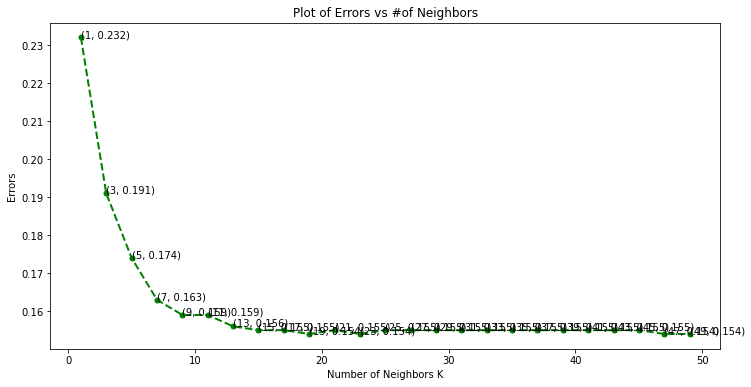

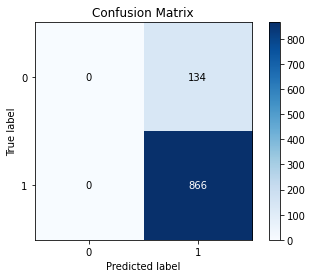

In [92]:
def tfidf_vectorise(dataset, fit_dataset):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #min_count = 5 considers only those words which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, vector_size=50, min_count=5, workers=6)
    word2vec_words = list(word2vec_model.wv.index_to_key)
    
    tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(fit_dataset)
    final_tf_idf_vectors = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names()
    
    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in word2vec_corpus: #For each review/sentence 
        sent_vec = np.zeros(50) #50 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum =0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = final_tf_idf_vectors[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review
                sent_vec += (word_vectors * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors


X_train_vectors = tfidf_vectorise(X_train, X_train)
X_test_vectors = tfidf_vectorise(X_test, X_train)

#Colum Standardization of the TF-IDF Average Word2Vec vectors created using cleaned data. This is done for both train and test Vectors.
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_train_vectors)
X_train_vectors = scalar.transform(X_train_vectors)
X_test_vectors = scalar.transform(X_test_vectors)
print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))

#Fitting the KNN to the TF-IDF Average Word2Vec model
knn_algo(X_train_vectors, Y_train, X_test_vectors, Y_test, "TF-IDF-Average-Word2Vec")

In [93]:
#Display information in a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (K=)", "Train Error", "Test Error", "F1-Score"]

print("Please find below the important metrics for all the models below.\n")
file = open('./info_model_KNN.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+-------------------------+-----------------------------+-------------+------------+----------+
|          Model          |  Hyper-Parameter Value (K=) | Train Error | Test Error | F1-Score |
+-------------------------+-----------------------------+-------------+------------+----------+
|      Bag-of-models      |              5              |    0.1556   |   0.133    |  0.9286  |
|      Bag-of-models      |              5              |    0.1556   |   0.133    |  0.9286  |
|      Bag-of-models      |              5              |    0.1556   |   0.133    |  0.9286  |
|      Bag-of-models      |              5              |    0.1556   |   0.133    |  0.9286  |
|          TF-IDF         |              3              |    0.155    |   0.132    |  0.929   |
|     Average-Word2Vec    |              19             |    0.1629   |   0.134    |  0.9282  |
| TF-IDF-Average-Word2Vec |              23             |    0.1608  

<b>As we can see, the most robust model is the TF-IDF model where the train and test errors are relatively lower than the other models.</b>

# Exploratory Data Analysis

## Data Cleaning

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values("ProductId", axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries

final = filtered_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)
print(final.shape)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [ ]:
preprocessed_reviews[1500]

In [ ]:
final.head()

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

In [ ]:
preprocessed_summary[100]

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split()) #list of arrays[['bought','several'],['vitality','canned']]

In [ ]:
len(list_of_sentance)

In [ ]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

In [ ]:
w2v_words = list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
tfidf_sent_vectors[0]

## PCA
<b>PCA</b> is one of the famous dimensionlaity reduction technique. <b>PCA</b> tries find the direction of the unit vector where the variance of projected vectors is <b>Maximum</b>.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
standardised_data = StandardScaler().fit_transform(tfidf_sent_vectors)

## PCA for visualisation
pca = PCA(n_components=2)
pca_reduced = pca.fit_transform(standardised_data)
print("Lenght of pca_reduced records: ",len(pca_reduced))
print("Corresponding class labels are, ",final["Class_Labels"].values)
# Appending the class labels to each of the components horizaontally row-wise
print(np.hstack((pca_reduced, np.array(final["Class_Labels"].values.reshape(len(final["Class_Labels"].values), 1)))))
pca_data = np.hstack((pca_reduced, np.array(final["Class_Labels"].values.reshape(len(final["Class_Labels"].values), 1))))
pca_df = pd.DataFrame(data=pca_data, columns=["1st_principal_component", "2nd_principal_component", "class_label"])
sns.FacetGrid(data = pca_df, hue="class_label").map(plt.scatter,'1st_principal_component', '2nd_principal_component').add_legend()
plt.show()

In [ ]:
## PCA for dimensionality reduction.
pca = PCA()
pca.n_components=standardised_data.shape[1]
pca_reduced = pca.fit_transform(standardised_data)
percentage_var_explained = pca.explained_variance_/np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)
print("Cumulative Explained variance is: ",cum_var_explained)
plt.plot(cum_var_explained)
plt.xlabel("#of components")
plt.ylabel("Cummulative % of variance explained")
plt.grid()
plt.show()

<b>Observation: </b>7 pricipal components are explaining 96% of the variance. Which means that out of 50 features we can consider these 7 components into consideration and make use for prediction as 96% variance is explained by this 7 components.

In [ ]:
final["Class_Labels"].values

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_reduced = tsne.fit_transform(tfidf_sent_vectors)
tsne_data = np.hstack((tsne_reduced, np.array(final["Class_Labels"].values.reshape(len(final["Class_Labels"].values), 1))))
tsne_df = pd.DataFrame(data=tsne_data, columns=["Dimension1", "Dimension2", "Class_Labels"])
sns.FacetGrid(data = tsne_df, hue="Class_Labels").map(plt.scatter, "Dimension1", "Dimension2").add_legend()
plt.show()